In [ ]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

!apt install imagemagick
!apt install ffmpeg
!cp -r drive/MyDrive/ColabNotebooks/Analysis/optimizers/ .
!cp -r drive/MyDrive/ColabNotebooks/Analysis/losses.py .
!cp -r drive/MyDrive/ColabNotebooks/Analysis/optimizer_classes.py .

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-

### Robustness to Noise in Dataset and Class Imbalance tests

In [ ]:
# We use logistic regression and one-layer MLP for the analysis
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features, n_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, n_classes)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

class MLP(torch.nn.Module):
    def __init__(self, n_input_features, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(n_input_features, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# Create a dataset with noise
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from optimizers.optim import SGD_C, SGD, Adam_C, Adam, RMSprop, RMSprop_C
from optimizers.optimExperimental import SAGA

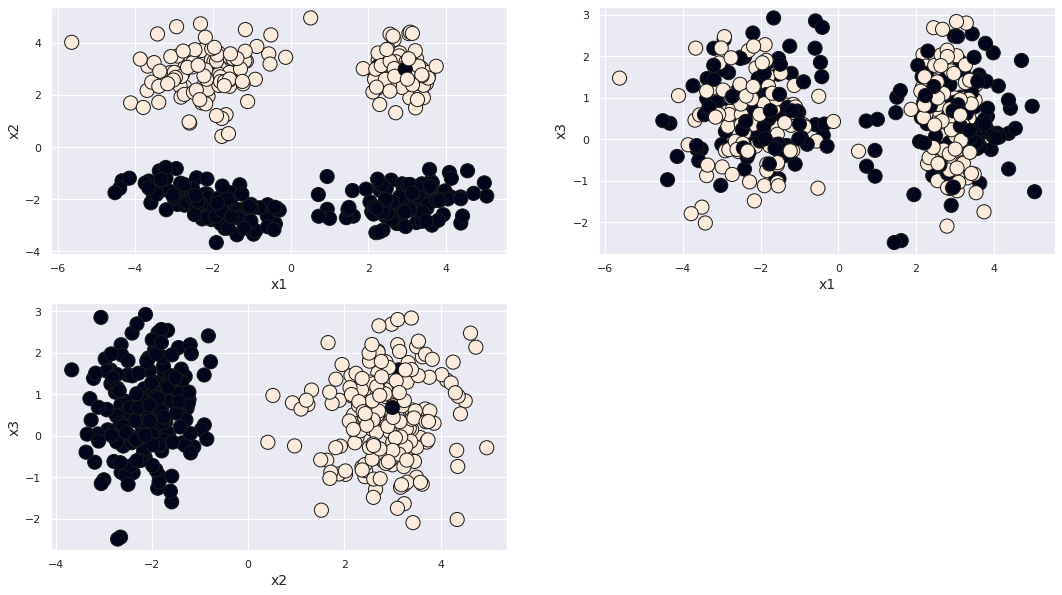

In [ ]:
# Plot and verify the dataset
# change flip_y to flip the targets at random ~~ to noise
# weights = [0.8,0.2] (n_classes-1 length to induce class imbalance)
from itertools import combinations
from math import ceil

data3 = make_classification(n_samples=400, n_features=3, n_informative=2, n_redundant=0, n_repeated=0, 
                            n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=2.5, 
                            hypercube=True, shift=0.4, scale=1.0, shuffle=True, random_state=42)

X, y = data3

df3 = pd.DataFrame(data3[0],columns=['x'+str(i) for i in range(1,4)])
df3['y'] = data3[1]

lst_var=list(combinations(df3.columns[:-1],2))
len_var = len(lst_var)
plt.figure(figsize=(18,10))
for i in range(1,len_var+1):
    plt.subplot(2,ceil(len_var/2),i)
    var1 = lst_var[i-1][0]
    var2 = lst_var[i-1][1]
    plt.scatter(df3[var1],df3[var2],s=200,c=df3['y'],edgecolor='k')
    plt.xlabel(var1,fontsize=14)
    plt.ylabel(var2,fontsize=14)
    plt.grid(True)

del data3

In [ ]:
# Train function

def trainModel(model_ = 'LR', optimizer_ = 'Adam', seed = '100', class_imbalance = None, noise = 0.01, class_sep = 1.0, loss_log = {}, Best = {}, exp = 'class_sep'): 
    
    # noise [0,1] : 0.01 is the default
    # higher values of class sep allows the classification task to be way easier [0,3] in 0.5 increments :1.0 is the default.
    # class_imbalance [0,1] fraction of samples in a class : None is the default
    
    num_epochs = 10
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    
    data3 = make_classification(n_samples=500, n_features=10, n_informative=7, n_redundant=0, n_repeated=0, 
                            n_classes=2, n_clusters_per_class=1, weights=class_imbalance, flip_y=noise, class_sep= 0.5, 
                            hypercube=True, shift=0.4, scale=1.0, shuffle=True, random_state=1403)

    #X, y = datasets.load_digits(return_X_y=True)#data3
    X, y = data3
    
    if model_ == 'LR':
        model = LogisticRegression(X.shape[1], max(y)+1 )
    elif model_ == 'MLP':
        model = MLP(X.shape[1],(max(y)+1)//2, max(y)+1)
        
    if optimizer_ == 'SGD':
        optimizer = SGD(model.parameters(),lr = 1e-3)
    elif optimizer_ == 'SGDM_C':
        optimizer = SGD_C(model.parameters(),lr = 1e-3, decay = 0.7, momentum = 0.9, kappa = 1.0, topC = 10)
    elif optimizer_ == 'SGDM':
        optimizer = SGD(model.parameters(),lr = 1e-3, momentum = 0.9)
    elif optimizer_ == 'Adam_C':
        optimizer = Adam_C(model.parameters(), lr = 1e-3, decay = 0.7, topC = 5)
    elif optimizer_ == 'Adam':
        optimizer = Adam(model.parameters(), lr = 1e-3)
    elif optimizer_ == 'SGD_C':
        optimizer = SGD_C(model.parameters(),lr = 1e-3, decay=0.7, topC = 5)
    elif optimizer_ == 'SGD_C_Only':
        optimizer = SGD_C_Only(model.parameters(),lr = 1e-3, decay=0.7, topC = 5)
    elif optimizer_ == 'RMSprop':
        optimizer = RMSprop(model.parameters(), lr = 1e-3)
    elif optimizer_ == 'RMSprop_C':
        optimizer = RMSprop_C(model.parameters(), lr = 1e-3, decay=0.7, topC = 5)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
        

    # Preprocessing step

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    X_train = torch.from_numpy(X_train.astype(np.float32))
    X_test = torch.from_numpy(X_test.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32)).long()
    y_test = torch.from_numpy(y_test.astype(np.float32)).long()

    # 3) Training loop
    for epoch in range(num_epochs):
        # Forward pass and loss
        for e in range(X_train.shape[0]):
            y_pred = model(X_train[e]).view(1,-1)
            loss = criterion(y_pred, y_train[e].view(-1))

            # Backward pass and update
            loss.backward()
            optimizer.step()
            # zero grad before new step
            optimizer.zero_grad()
      
        y_predicted = model(X_train).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        acc = y_predicted.eq(y_train.view_as(y_predicted)).sum() *100. / float(y_train.shape[0])
        train_acc = f1_score(y_train, y_predicted.view_as(y_train), average='micro')#acc.item()
        
        with torch.no_grad():
            y_predicted = model(X_test).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            acc = y_predicted.eq(y_test.view_as(y_predicted)).sum() *100. / float(y_test.shape[0])
            test_acc = f1_score(y_test, y_predicted.view_as(y_test), average='micro')#acc.item()
            if seed in loss_log:
                if epoch+1 in loss_log[seed]:
                    loss_log[seed][epoch+1].update({optimizer_: {'train_f1':"{:.2f}".format(train_acc), 'test_f1':"{:.2f}".format(test_acc), 'g_error':"{:.2f}".format(abs(test_acc-train_acc))}})
                else:
                    loss_log[seed].update({epoch+1:{optimizer_: {'train_f1':"{:.2f}".format(train_acc), 'test_f1':"{:.2f}".format(test_acc), 'g_error':"{:.2f}".format(abs(test_acc-train_acc))}}})
            else:
                loss_log.update({seed:{epoch+1:{optimizer_: {'train_f1':"{:.2f}".format(train_acc), 'test_f1':"{:.2f}".format(test_acc), 'g_error':"{:.2f}".format(abs(test_acc-train_acc))}}}})
        
        val = eval(exp)[0] if exp == 'class_imbalance' else eval(exp)
        if seed in Best:
            if optimizer_ in Best[seed]:
                if val in Best[seed][optimizer_]:
                    if float(Best[seed][optimizer_][val]['f1']) < test_acc:
                        Best[seed][optimizer_][val]['f1'] = "{:.2f}".format(test_acc)
                        Best[seed][optimizer_][val]['epoch'] = epoch
                else:
                    Best[seed][optimizer_].update({val:{'f1':"{:.2f}".format(test_acc), 'epoch': epoch}})
            else:
                Best[seed].update({optimizer_:{val:{'f1':"{:.2f}".format(test_acc), 'epoch': epoch}}})
        else:
            Best.update({seed:{optimizer_:{val:{'f1':"{:.2f}".format(test_acc), 'epoch': epoch}}}})
    return loss_log, Best

100
101
102
103
104
{100: {'SGD_C': {0.0: {'f1': '0.85', 'epoch': 7}, 0.1: {'f1': '0.84', 'epoch': 5}, 0.2: {'f1': '0.81', 'epoch': 8}, 0.3: {'f1': '0.72', 'epoch': 3}, 0.4: {'f1': '0.72', 'epoch': 3}, 0.5: {'f1': '0.67', 'epoch': 8}, 0.6: {'f1': '0.74', 'epoch': 8}, 0.7: {'f1': '0.59', 'epoch': 2}, 0.8: {'f1': '0.67', 'epoch': 9}, 0.9: {'f1': '0.65', 'epoch': 3}, 1.0: {'f1': '0.59', 'epoch': 0}}, 'SGD': {0.0: {'f1': '0.81', 'epoch': 8}, 0.1: {'f1': '0.83', 'epoch': 8}, 0.2: {'f1': '0.82', 'epoch': 9}, 0.3: {'f1': '0.70', 'epoch': 8}, 0.4: {'f1': '0.74', 'epoch': 7}, 0.5: {'f1': '0.65', 'epoch': 5}, 0.6: {'f1': '0.74', 'epoch': 8}, 0.7: {'f1': '0.62', 'epoch': 3}, 0.8: {'f1': '0.67', 'epoch': 9}, 0.9: {'f1': '0.56', 'epoch': 8}, 1.0: {'f1': '0.49', 'epoch': 8}}}, 101: {'SGD_C': {0.0: {'f1': '0.83', 'epoch': 9}, 0.1: {'f1': '0.85', 'epoch': 4}, 0.2: {'f1': '0.80', 'epoch': 9}, 0.3: {'f1': '0.72', 'epoch': 6}, 0.4: {'f1': '0.71', 'epoch': 9}, 0.5: {'f1': '0.66', 'epoch': 8}, 0.6: {'f1': 

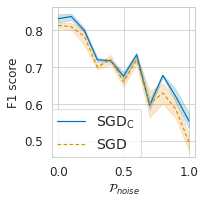

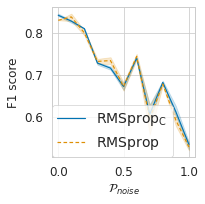

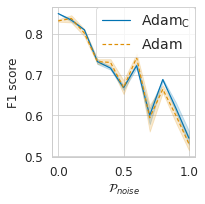

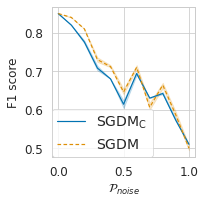

In [ ]:
import seaborn as sns
import csv
sns.set()
def plotLoss(model_ = 'LR', title = 'Variance to Noise', exp = 'class_sep', opts = ['Adam_C','Adam']):
    if exp != None:
      fieldnames=['Seed','Optimizer', exp, 'F1 score']
    else:
      fieldnames=['Seed','Optimizer', 'Epochs', 'F1 score']
    target = open("temp.csv", "w")
    writer = csv.DictWriter(target, fieldnames=fieldnames)
    writer.writerow(dict(zip(fieldnames, fieldnames)))
    
    loss_log = {} # Used to sanity check.
    Best = {}
    for s in [100, 101, 102, 103, 104]:
        
    # noise [0,1] : 0.01 is the default
    # higher values of class sep allows the classification task to be way easier [0,3] in 0.5 increments :1.0 is the default.
    # class_imbalance [0,1] fraction of samples in a class : None is the default
      torch.manual_seed(s)
      print(s)
      for o in opts:
        if exp == 'Units_of_Separation':
          for it_ in range(1,37,5): # (1,102) for noise (1,32) for class imbalance, (1,102) for noise , (1,37) for class sep
            _, Best = trainModel(model_ = model_, optimizer_ = o , seed = s, class_imbalance = None , noise = 0.01, class_sep = float("{:.2f}".format(0.1*(it_-1))), loss_log = loss_log, Best = Best, exp = 'class_sep')
        if exp == 'Fraction_of_Minority_Class':
          for it_ in range(11,52,10):
                _, Best = trainModel(model_ = model_, optimizer_ = o , seed = s, class_imbalance = [float("{:.2f}".format(0.01*(it_-1)))] , noise = 0.01, class_sep = 1.0, loss_log = loss_log, Best = Best, exp = 'class_imbalance')
        if exp == '$\mathcal{P}_{noise}$':
          for it_ in range(1,102,10):
            _, Best = trainModel(model_ = model_, optimizer_ = o , seed = s, class_imbalance = None , noise = float("{:.2f}".format(0.01*(it_-1))), class_sep = 0.1, loss_log = loss_log, Best = Best, exp = 'noise')
        if exp == None:
          loss_log, Best = trainModel(model_ = model_, optimizer_ = o , seed = s, class_imbalance = None , noise = 0.01, class_sep = 0.1, loss_log = loss_log, Best = Best, exp = 'noise')

    print(Best)
    if exp == None:
      print('hi')
      for seed, s_rest in loss_log.items():
        for epoch, e_rest in s_rest.items():
          for opt, o_rest in e_rest.items():
            writer.writerow(dict([
                    ('Seed', seed),
                    ('Optimizer', opt),
                    ('Epochs', epoch),
                    ('F1 score',o_rest['test_f1'])])
                    )
      target.close()
      sns.lineplot(x = 'Epochs', y = 'F1 score', hue = 'Optimizer',data = pd.read_csv('temp.csv'))
      plt.legend(loc=0., borderaxespad=0.)
      plt.show()
    else:
      for seed, s_rest in Best.items():
        for optimizer, o_rest in s_rest.items():
          for val, v_rest in o_rest.items():
            writer.writerow(dict([
                    ('Seed', seed),
                    ('Optimizer', '$\mathrm{'+optimizer+'}$'),
                    (exp, val),
                    ('F1 score',v_rest['f1'])])
                    )
      target.close()
    
    df = pd.read_csv('temp.csv')
    print(df)

    plt.figure(figsize=(3, 3))
    rc = {'axes.labelsize': 12,
          'axes.linewidth': 1.0,
          'axes.titlesize': 12,
          'font.size': 12,
          'grid.linewidth': 0.8,
          'legend.fontsize': 14,
          'legend.title_fontsize': 14,
          'lines.linewidth': 1.2000000000000002,
          'lines.markersize': 4.800000000000001,
          'patch.linewidth': 0.8,
          'xtick.labelsize': 12,
          'xtick.major.size': 5,
          'xtick.major.width': 1.5,
          'xtick.minor.size': 0,
          'xtick.minor.width': 0.8,
          'ytick.labelsize': 12,
          'ytick.major.size': 5,
          'ytick.major.width': 5,
          'ytick.minor.size': 0,
          'ytick.minor.width': 0.8}
    sns.set(rc=rc)
    sns.set_style('whitegrid')

    known_optims = ['$\mathrm{SGD}$', '$\mathrm{SGD_C}$', '$\mathrm{SGDM}$', '$\mathrm{SGDM_C}$', '$\mathrm{RMSprop}$', '$\mathrm{RMSprop_C}$', '$\mathrm{Adam}$', '$\mathrm{Adam_C}$']
    colors = sns.color_palette("colorblind", 2)
    palette = {}
    for optim in known_optims:
      if "_C" in optim:
        palette[optim] = colors[0]
      else:
        palette[optim] = colors[1]
    dashes = {'$\mathrm{SGD_C}$': "", '$\mathrm{SGD}$': (3, 2), '$\mathrm{SGDM_C}$': "", '$\mathrm{SGDM}$': (3, 2), '$\mathrm{RMSprop_C}$': "", '$\mathrm{RMSprop}$': (3, 2), '$\mathrm{Adam_C}$': "", '$\mathrm{Adam}$': (3, 2)}
    ax = sns.lineplot(x = exp, y = 'F1 score', hue = 'Optimizer', data = df, palette = palette, style = 'Optimizer', dashes= dashes)
    plt.legend(loc=0, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(exp+'-'+'_'.join(opts)+'.png')

#plotLoss(title = 'Variance to overlapping boundaries', exp = 'Units_of_Separation')
#plotLoss(title = 'Variance to Minority class', exp = 'class_imbalance')
#plotLoss(title = 'Variance to Noise', exp = 'Fraction_of_Noise')
#plotLoss(title = 'Variance to Minority class', exp = 'Fraction_of_Minority_Class', opts = ['Adam_C','Adam'])#, 'RMSprop','Adam', 'Adam_C', 'RMSprop_C', 'SGDM','SGDM_C'])
plotLoss(title = 'Variance to Noise', exp = '$\mathcal{P}_{noise}$', opts = ['SGD_C','SGD'])
plotLoss(title = 'Variance to Noise', exp = '$\mathcal{P}_{noise}$', opts = ['RMSprop_C','RMSprop'])
plotLoss(title = 'Variance to Noise', exp = '$\mathcal{P}_{noise}$', opts = ['Adam_C','Adam'])
plotLoss(title = 'Variance to Noise', exp = '$\mathcal{P}_{noise}$', opts = ['SGDM_C','SGDM'])
# plotLoss pd.read_csv('temp.csv')

### Comparing Optimizers on different loss surfaces

In [ ]:
from matplotlib import cm
import sys

from optimizer_classes import Optimizer

import pylab as plt
import matplotlib
matplotlib.use
import matplotlib.animation as anim
import numpy as np
import torch
import matplotlib.pyplot as mpl
from matplotlib.colors import LogNorm
import seaborn as sns

from collections import OrderedDict

from matplotlib.animation import FuncAnimation
import os

%matplotlib inline

def set_figsize(figw, figh, fig=None):
    if not fig:
        fig = plt.gcf()
    w, h = fig.get_size_inches()
    l = fig.subplotpars.left
    r = fig.subplotpars.right
    t = fig.subplotpars.top
    b = fig.subplotpars.bottom
    hor = 1.-w/float(figw)*(r-l)
    ver = 1.-h/float(figh)*(t-b)
    fig.subplots_adjust(left=hor/2., right=1.-hor/2., top=1.-ver/2., bottom=ver/2.)


def init_plot(compute_loss, func_name):
    fig = plt.figure(figsize=(3, 3))

    sns.set_style('whitegrid') 
    sns.set_context("paper")
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    
    plt.axis('off')
    
    # visualize cost function as a contour plot
    if func_name == 'Beale':
        x_points = np.linspace(-2.0, 3.5, 50) 
        y_points = np.linspace(-3.0, 3.0, 50)
    if func_name == 'SixHumpCamel':
        x_points = np.linspace(-3.0, 3.5, 50) 
        y_points = np.linspace(-3.0, 3.0, 50)
    if func_name == 'GoldsteinPrice':
        x_points = np.linspace(-2.0, 1.0, 50) 
        y_points = np.linspace(-2.0, 1.0, 50)
    w1_val_mesh, w2_val_mesh = np.meshgrid(x_points, y_points)
    
    z = np.array([compute_loss([torch.tensor(xps), torch.tensor(yps)]).detach().numpy() for xps, yps in zip(w1_val_mesh, w2_val_mesh)])

    ax.contour(w1_val_mesh, w2_val_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    
    return fig, ax


def getGif(func_name = 'Beale', n_epochs = 1000, opts = ['SGD',  'SGD_C', 'Adam', 'Adam_C', 'RMSprop', 'RMSprop_C', 'SGDM'], no_anim = False):
    optimizer_list = [Optimizer(name, func_name = func_name) for name in opts]#, "SGD"]]
        
    fig, ax = init_plot(optimizer_list[0].loss_func.get_func_val, func_name = func_name)
    
    
    for o in optimizer_list:
        ln, = ax.plot([], [], o.color+'+', label = o.name)
    ax.set_xlabel('x', size=22)
    ax.set_ylabel('y', size=22)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    def update(i, optimizer_list):
        for k in range(100):
            for j in range(len(optimizer_list)):
                model = optimizer_list[j]
                loss = model.train_step()
                ln = optimizer_list[j].plot(ax)
            ax.set_title(func_name + '\n'+'After '+str(i)+' updates')
        return ln

    
    
    # a = anim.FuncAnimation(fig, update, frames=range(0,n_epochs+1,100), interval=1, fargs=(optimizer_list,), repeat=True)
    # print(func_name+'_'+'_'.join(opts)+'.gif')
    # FFwriter = anim.PillowWriter(fps=30)
    # a.save(func_name+'_'+'_'.join(opts)+'.gif', writer=FFwriter)
    #plt.show()

def main(func_name = 'Beale',n_epochs = 1000, opts = ['SGD_C', 'SGD', 'SGD_C_Only']):
  optimizer_list = [Optimizer(name, func_name = func_name) for name in opts]#, "SGD"]]

  fig, ax = init_plot(optimizer_list[0].loss_func.get_func_val, func_name = func_name)

  M_list = {} # minimum loss observed thus far

  

  for i in range(n_epochs):
    d = {}
    for j in range(len(optimizer_list)):
      model = optimizer_list[j]
      loss = model.train_step()
      ln = optimizer_list[j].plot(ax)
      d.update({opts[j]: float(loss)})
    if i%100 == 0:
      handles, labels = plt.gca().get_legend_handles_labels()
      by_label = OrderedDict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys())
      plt.savefig(os.path.join('Figures',func_name+'_'+str(i)+'.png'))
    M_list.update({i:d})
  plt.close()
          
  return M_list

m = main(func_name = 'SixHumpCamel',n_epochs = 501, opts = ['SGD_C', 'Adam_C'])
 
# getGif(func_name = 'Beale', n_epochs = 1000)
# getGif(func_name = 'GoldsteinPrice', n_epochs = 1000)
# for fn in ['GoldsteinPrice', 'SixHumpCamel']:
#   getGif(func_name = fn, n_epochs = 5000, opts = ['RMSprop', 'RMSprop_C'])
#   getGif(func_name = fn, n_epochs = 5000, opts = ['Adam', 'Adam_C'])
#   getGif(func_name = fn, n_epochs = 5000, opts = ['SGD', 'SGD_C','SGDM'])
#   getGif(func_name = fn, n_epochs = 5000, opts = ['Adam_C', 'SGD_C','RMSprop_C'])

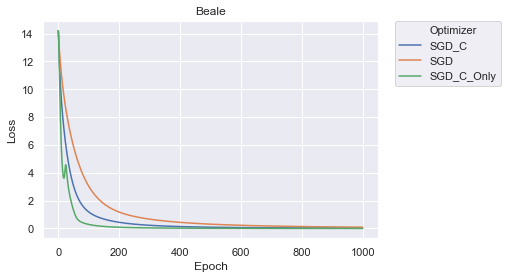

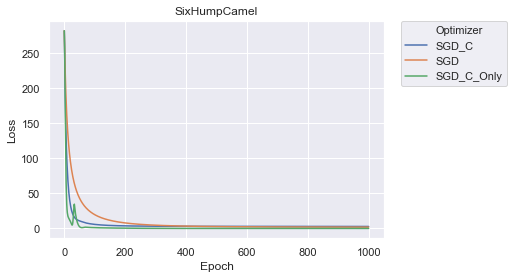

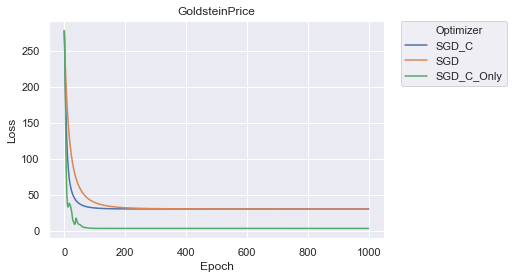

In [ ]:
import seaborn as sns
import csv
import pandas as pd
sns.set()

color = ['b','y','r']
opts = ['SGD_C', 'SGD', 'SGD_C_Only']

def CompareOpts(func_name = 'Beale', opts = ['SGD_C', 'SGD', 'Adam_C', 'RMSprop', 'RMSprop_C', 'SGDM']):
    M_list = main(func_name, opts = opts )
    fieldnames=['Epoch','Optimizer', 'Loss']
    target = open("temp.csv", "w")
    writer = csv.DictWriter(target, fieldnames=fieldnames)
    writer.writerow(dict(zip(fieldnames, fieldnames)))
    
    for i, rest in M_list.items():
        for opt_name, loss in rest.items():
            writer.writerow(dict([
                    ('Epoch', i),
                    ('Optimizer', opt_name),
                    ('Loss',loss)])
                    )
    target.close()
    sns.lineplot(x = 'Epoch', y = 'Loss', hue = 'Optimizer',data = pd.read_csv('temp.csv'))
    plt.title(func_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

for fn in ['Beale','SixHumpCamel','GoldsteinPrice']:
    CompareOpts(func_name = fn, opts = ['SGD_C', 'SGD', 'Adam_C', 'RMSprop', 'RMSprop_C', 'SGDM'])